In [198]:
!pip install pandas
!pip install matplotlib seaborn

In [199]:
import plistlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import normaltest
from scipy.stats import linregress
from scipy.stats import kruskal

# Loading the iTunes XML file
with open('apple music library.xml','rb') as f:
    plist = plistlib.load(f)

# Extracting necessary track info
tracks = plist['Tracks']
track_list = []

for track_id, track in tracks.items():
    # We only want tracks with the required fields
    if all (k in track for k in ('Name', 'Artist', 'Play Count', 'Genre', 'Release Date')):
        track_list.append({
            'Name': track.get('Name'),
            'Artist': track.get('Artist'),
            'Album': track.get('Album'),
            'Play Count': track.get('Play Count',0),
            'Genre': track.get('Genre'),
            'Release Date': track.get('Release Date'),
            'Date Added': track.get('Date Added'),
            'Total Time (s)': track.get('Total Time', 0) / 1000})

# Create dataframe

df = pd.DataFrame(track_list)

# Remove songs with play count of 0

df = df[df['Play Count'] > 0]

# Combining genres due to common artists in both

df = df.replace(('Adult Alternative','Hip-Hop','TV Soundtrack'),('Alternative','Hip-Hop/Rap','Soundtrack'))

## Creating a list of the top 10 genres by average plays per song for genres with at least 10 songs

# Group by genre
genre_stats = df.groupby('Genre').agg({
    'Play Count': 'mean',
    'Name': 'count'  # Number of songs per genre
}).rename(columns={'Name': 'Track Count'})

# Filter to genres with at least 10 songs
genre_stats = genre_stats[genre_stats['Track Count'] >= 10]

# Get top 10 genres by average play count
top_genres = genre_stats.sort_values(by='Play Count', ascending=False).head(10).index

# Keeping only songs in top genres
df_clean = df[df['Genre'].isin(top_genres)].reset_index(drop=True)

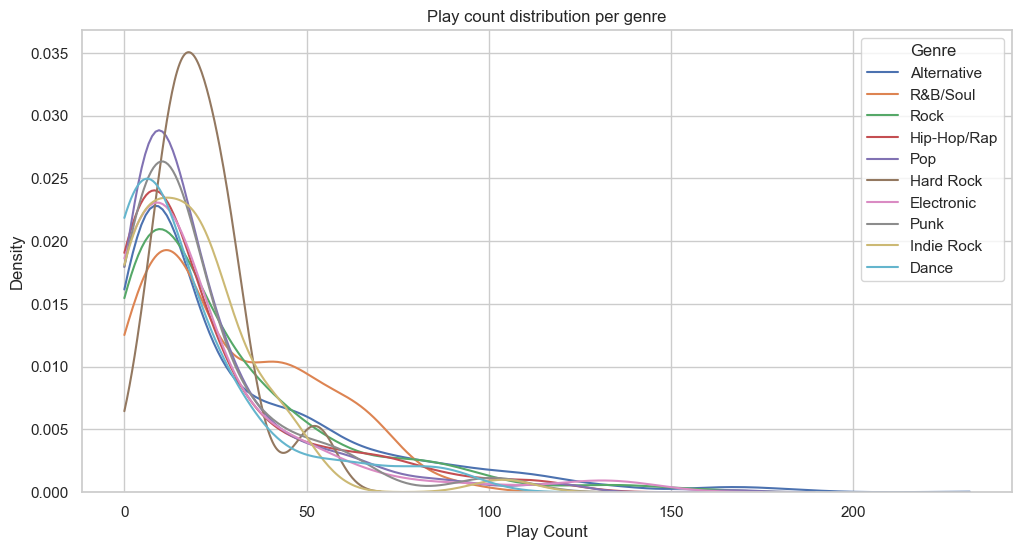

In [200]:
# Setting up plot
plt.figure(figsize=(12,6))

# Loop through genres and plot KDE
for genre in top_genres:
    indiv_genre = df_clean[df_clean['Genre'] == genre]
    sns.kdeplot(indiv_genre['Play Count'], label = genre, fill = False, common_norm = False, clip=(0,232))

# To make it pretty
plt.title('Play count distribution per genre')
plt.xlabel('Play Count')
plt.ylabel('Density')
plt.legend(title = 'Genre', loc = 'upper right')
plt.grid(True)
plt.show()

In [201]:
# Test for normaility
normal_test_results = []

# Loop through genres
for genre in top_genres:
    indiv_genre = df[df['Genre'] == genre]['Play Count']
    stat, p = normaltest(indiv_genre)
    normal_test_results.append({
        'Genre' : genre,
        '# of Songs' : len(indiv_genre),
        'Stat' : round(stat,3),
        'p-Value' : round(p,10),
        'Normal?' : 'Yes' if p > 0.05 else 'No'})

test_results_df = pd.DataFrame(normal_test_results)
test_results_df

,Genre,# of Songs,Stat,p-Value,Normal?
0,Alternative,1210,442.516,0.000000e+00,No
1,R&B/Soul,96,9.249,9.809854e-03,No
2,Rock,365,133.527,0.000000e+00,No
3,Hip-Hop/Rap,121,48.084,0.000000e+00,No
4,Pop,345,187.620,0.000000e+00,No
5,Hard Rock,39,10.704,4.738971e-03,No
6,Electronic,61,50.455,0.000000e+00,No
7,Punk,33,29.117,4.757000e-07,No
8,Indie Rock,47,40.737,1.400000e-09,No
9,Dance,40,23.522,7.801200e-06,No


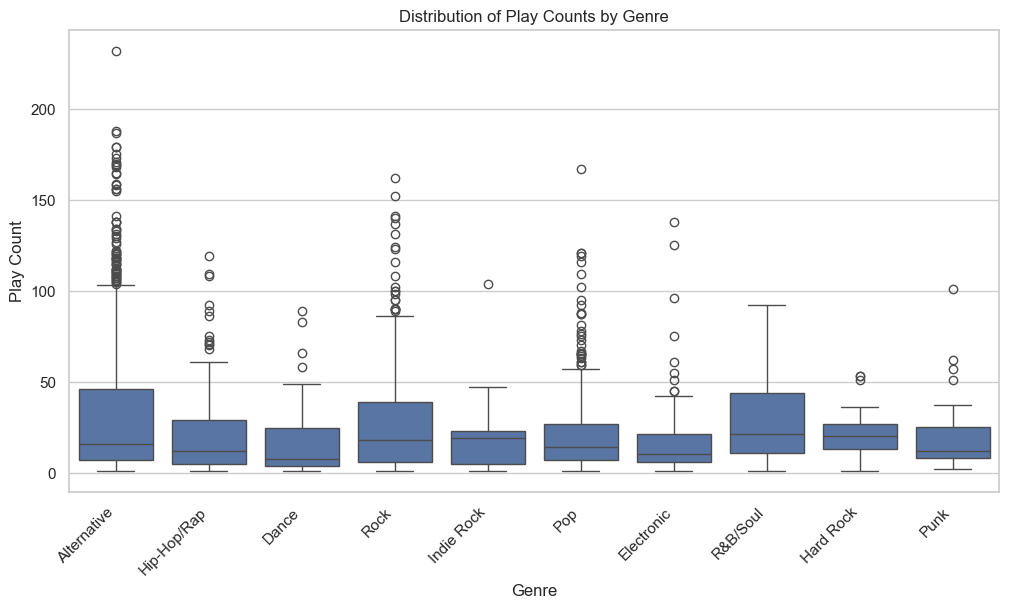

In [202]:
# Plotting a boxplot for play count by genre
plt.figure(figsize=(12, 6))
sns.boxplot(x='Genre', y='Play Count', data=df_clean)

plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Play Counts by Genre')
plt.xlabel('Genre')
plt.ylabel('Play Count')
plt.show()

In [203]:
# Testing for play count distribution between genres using the Kruskal-Wallis test
groups = [group['Play Count'].values for name, group in genre_stats.groupby('Play Count')]
stat, p = kruskal(*groups)
print(f"H statistic = {stat:.2f}, p = {p:.4f}")

H statistic = 13.00, p = 0.4478


In [204]:
# Create correlation for chosen columns
df_corr = df_clean[['Play Count', 'Total Time (s)', 'Date Added']]
df_corr.corr()

,Play Count,Total Time (s),Date Added
Play Count,1.000000,-0.051140,-0.257254
Total Time (s),-0.051140,1.000000,-0.051434
Date Added,-0.257254,-0.051434,1.000000


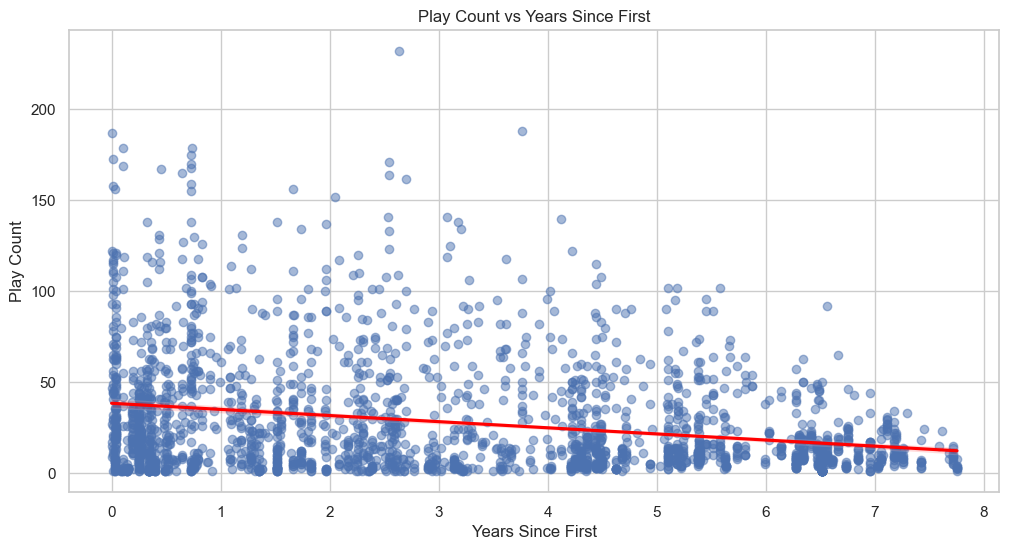

In [205]:
# Converting date added to integer type
df_clean['Date Added'] = pd.to_datetime(df_clean['Date Added'])
df_clean['Years Since First'] = (df_clean['Date Added'] - df_clean['Date Added'].min()).dt.days/365

# Plotting play count against date added
sns.set(style="whitegrid")
plt.figure(figsize =(12,6))
sns.regplot(x='Years Since First', y='Play Count', data=df_clean, scatter_kws={'alpha': 0.5}, line_kws={'color':'red'})
plt.title('Play Count vs Years Since First')
plt.xlabel('Years Since First')
plt.ylabel('Play Count')
plt.grid(True)
plt.show()

In [206]:
# Calculating the gradient of the regression line
slope, *_ = linregress(df_clean['Years Since First'],df_clean['Play Count'])
print(f'The gradient of the line is: {slope}')

The gradient of the line is: -3.370165222035746
